In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader

# Import custom modules
from data_preparation import load_and_preprocess_data, prepare_sequence_data, split_data_by_race, save_data_splits, prepare_regression_data
from features import RaceFeatures
from lstm import F1PredictionModel, F1Dataset, F1DataPreprocessor, train_model, save_model_with_preprocessor
from evaluation import evaluate_model, plot_predictions

# Load and preprocess data
print("Loading and preprocessing data...")
df = load_and_preprocess_data()

df.head()


Loading and preprocessing data...


/Users/I551659/Documents/GitHub/IE650-RAMP/ie500-data-mining-group7/lap_simulation/data_preparation.py:25: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  practice_sessions = pd.read_csv('../data/raw_data/ff1_laps.csv', na_values=na_values)
/Users/I551659/Documents/GitHub/IE650-RAMP/ie500-data-mining-group7/lap_simulation/data_preparation.py:26: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  tire_data = pd.read_csv('../data/raw_data/ff1_laps.csv', na_values=na_values)


(586171, 15)
(586171, 32)
(586171, 40)
(586171, 45)
(586171, 46)
(586171, 47)
(586171, 47)


/Users/I551659/Documents/GitHub/IE650-RAMP/ie500-data-mining-group7/lap_simulation/data_preparation.py:79: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  laps['pitstop_milliseconds'].fillna(0, inplace=True)  # Assuming 0 if no pit stop
/Users/I551659/Documents/GitHub/IE650-RAMP/ie500-data-mining-group7/lap_simulation/data_preparation.py:108: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method

(159538, 56)


/Users/I551659/Documents/GitHub/IE650-RAMP/ie500-data-mining-group7/lap_simulation/data_preparation.py:226: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  laps['Compound'].fillna('UNKNOWN', inplace=True)
/Users/I551659/Documents/GitHub/IE650-RAMP/ie500-data-mining-group7/lap_simulation/data_preparation.py:282: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the int

Shape of laps before merging weather data: (159538, 65)

Processing race 989 (2018 AUSTRALIAN GRAND PRIX)
No weather data found for race - Assigning default weather values

Processing race 990 (2018 BAHRAIN GRAND PRIX)
No weather data found for race - Assigning default weather values

Processing race 991 (2018 CHINESE GRAND PRIX)
No weather data found for race - Assigning default weather values

Processing race 992 (2018 AZERBAIJAN GRAND PRIX)
No weather data found for race - Assigning default weather values

Processing race 993 (2018 SPANISH GRAND PRIX)
No weather data found for race - Assigning default weather values

Processing race 994 (2018 MONACO GRAND PRIX)
No weather data found for race - Assigning default weather values

Processing race 995 (2018 CANADIAN GRAND PRIX)
No weather data found for race - Assigning default weather values

Processing race 996 (2018 FRENCH GRAND PRIX)
No weather data found for race - Assigning default weather values

Processing race 997 (2018 AUSTRIAN

/Users/I551659/Documents/GitHub/IE650-RAMP/ie500-data-mining-group7/lap_simulation/data_preparation.py:385: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  laps_with_weather['TrackTemp'].fillna(25.0, inplace=True)
/Users/I551659/Documents/GitHub/IE650-RAMP/ie500-data-mining-group7/lap_simulation/data_preparation.py:386: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work becaus

Shape of laps after merging weather data: (159538, 64)
No duplicate rows found after merging weather data.


/Users/I551659/Documents/GitHub/IE650-RAMP/ie500-data-mining-group7/lap_simulation/data_preparation.py:657: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  laps['TrackStatus'].fillna(1, inplace=True)  # 1 = regular racing status


Shape before filtering and outlier removal: (159538, 73)
Normal racing laps: (141117, 73)
Special laps (pit stops, safety car, etc.): (18421, 73)
Final shape after outlier removal: (148148, 73)


,raceId,driverId,lap,position,time,milliseconds,date,driverRef,number,code,...,Humidity,driver_aggression,driver_overall_skill,driver_circuit_skill,driver_consistency,driver_reliability,driver_risk_taking,tire_age,fuel_load,track_position
0,989,1,1,1,1:34.233,94233,2018-03-25,hamilton,44.0,HAM,...,50.0,0.212465,0.364554,0.364554,0.0,0.9,0.212465,0,58,1
1,989,1,2,1,1:30.265,90265,2018-03-25,hamilton,44.0,HAM,...,50.0,0.212465,0.364554,0.364554,0.0,0.9,0.212465,1,57,1
2,989,1,3,1,1:29.809,89809,2018-03-25,hamilton,44.0,HAM,...,50.0,0.212465,0.364554,0.364554,0.0,0.9,0.212465,2,56,1
3,989,1,4,1,1:29.473,89473,2018-03-25,hamilton,44.0,HAM,...,50.0,0.212465,0.364554,0.364554,0.0,0.9,0.212465,3,55,1
4,989,1,5,1,1:29.161,89161,2018-03-25,hamilton,44.0,HAM,...,50.0,0.212465,0.364554,0.364554,0.0,0.9,0.212465,4,54,1


In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA


# One hot encoding for the column "code"


X = df.drop(columns=["cumulative_milliseconds", "positionOrder", "date", "driverRef", "number", "date_race", "time_race", "time", "forename", "surname", "dob", "url_race", "location", "circuitRef"])


X = X.drop(columns=["milliseconds"])
y = df["milliseconds"]

X.head()

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129727 entries, 0 to 129726
Data columns (total 44 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   raceId                   129727 non-null  int64  
 1   driverId                 129727 non-null  int64  
 2   lap                      129727 non-null  int64  
 3   position                 129727 non-null  int64  
 4   code                     129727 non-null  object 
 5   nationality              129727 non-null  object 
 6   year                     129727 non-null  int64  
 7   round                    129727 non-null  int64  
 8   circuitId                129727 non-null  int64  
 9   country                  129727 non-null  object 
 10  lat                      129727 non-null  float64
 11  lng                      129727 non-null  float64
 12  alt                      129727 non-null  int64  
 13  grid                     129727 non-null  int64  
 14  stat

In [3]:
X = pd.get_dummies(
    X, columns=["code", "nationality", "status", "circuit_type", "country"]
)

In [4]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
X_normalized = scaler.fit_transform(X)

# Convert the normalized data back to a DataFrame
X_normalized = pd.DataFrame(X_normalized, columns=X.columns)

# Display the first few rows of the normalized data
X_normalized.head()

,raceId,driverId,lap,position,year,round,circuitId,lat,lng,alt,...,country_Qatar,country_Russia,country_Saudi Arabia,country_Singapore,country_Spain,country_Turkey,country_UAE,country_UK,country_USA,country_United States
0,-1.680715,-2.196964,-1.703409,-1.604968,-1.514039,-1.638024,-1.072332,-3.301535,2.225707,-0.539917,...,-0.117949,-0.159235,-0.147465,-0.192254,-0.250209,-0.11636,-0.215379,-0.215927,-0.256651,-0.075537
1,-1.680715,-2.196964,-1.647698,-1.604968,-1.514039,-1.638024,-1.072332,-3.301535,2.225707,-0.539917,...,-0.117949,-0.159235,-0.147465,-0.192254,-0.250209,-0.11636,-0.215379,-0.215927,-0.256651,-0.075537
2,-1.680715,-2.196964,-1.591988,-1.604968,-1.514039,-1.638024,-1.072332,-3.301535,2.225707,-0.539917,...,-0.117949,-0.159235,-0.147465,-0.192254,-0.250209,-0.11636,-0.215379,-0.215927,-0.256651,-0.075537
3,-1.680715,-2.196964,-1.536277,-1.604968,-1.514039,-1.638024,-1.072332,-3.301535,2.225707,-0.539917,...,-0.117949,-0.159235,-0.147465,-0.192254,-0.250209,-0.11636,-0.215379,-0.215927,-0.256651,-0.075537
4,-1.680715,-2.196964,-1.480567,-1.604968,-1.514039,-1.638024,-1.072332,-3.301535,2.225707,-0.539917,...,-0.117949,-0.159235,-0.147465,-0.192254,-0.250209,-0.11636,-0.215379,-0.215927,-0.256651,-0.075537


In [5]:
# Assuming X_train_scaled is already scaled data from StandardScaler

# Fit PCA
pca = PCA(n_components=None)
dfx_pca = pca.fit(X_normalized)

# Retrieve eigenvectors (components/loadings)
eigenvectors = pca.components_  # Shape: (n_components, n_features)

# Retrieve eigenvalues (explained variance)
eigenvalues = pca.explained_variance_


# Explained variance ratio (proportion of variance explained by each component)
explained_variance_ratio = pca.explained_variance_ratio_

# Create a DataFrame for loadings
loadings = pd.DataFrame(
    eigenvectors.T,  # Transpose to align features as rows and PCs as columns
    columns=[f"PC{i+1}" for i in range(eigenvectors.shape[0])],
    index=X.columns,  # Assuming columns are the feature names
)

# Display the loadings
print("PCA Loadings (Feature Contributions):")
print(loadings)

# Explained variance
print("\nExplained Variance Ratio:")
print(
    pd.Series(
        explained_variance_ratio,
        index=[f"PC{i+1}" for i in range(len(explained_variance_ratio))],
    )
)

# Most important features for PC1
important_features_pc1 = loadings["PC1"].abs().sort_values(ascending=False)
print("\nMost Important Features for PC1:")
print(important_features_pc1)

PCA Loadings (Feature Contributions):
                            PC1       PC2       PC3       PC4       PC5  \
raceId                 0.034459  0.366911 -0.182460 -0.031968  0.031504   
driverId              -0.035532  0.119141 -0.039201 -0.007977 -0.108198   
lap                    0.006947 -0.053537 -0.214764  0.456377  0.006299   
position              -0.250547  0.047472 -0.018535 -0.035819  0.055465   
year                   0.034820  0.362612 -0.177196 -0.028809  0.028994   
...                         ...       ...       ...       ...       ...   
country_Turkey        -0.002023 -0.021984  0.055039  0.019171  0.001967   
country_UAE           -0.001812  0.024637  0.098685  0.026445  0.015910   
country_UK             0.004923 -0.001529  0.048588  0.018426 -0.002113   
country_USA            0.005000  0.114876 -0.004662 -0.015787  0.020107   
country_United States  0.001749  0.023651 -0.026471 -0.003579 -0.000940   

                            PC6       PC7       PC8       PC9

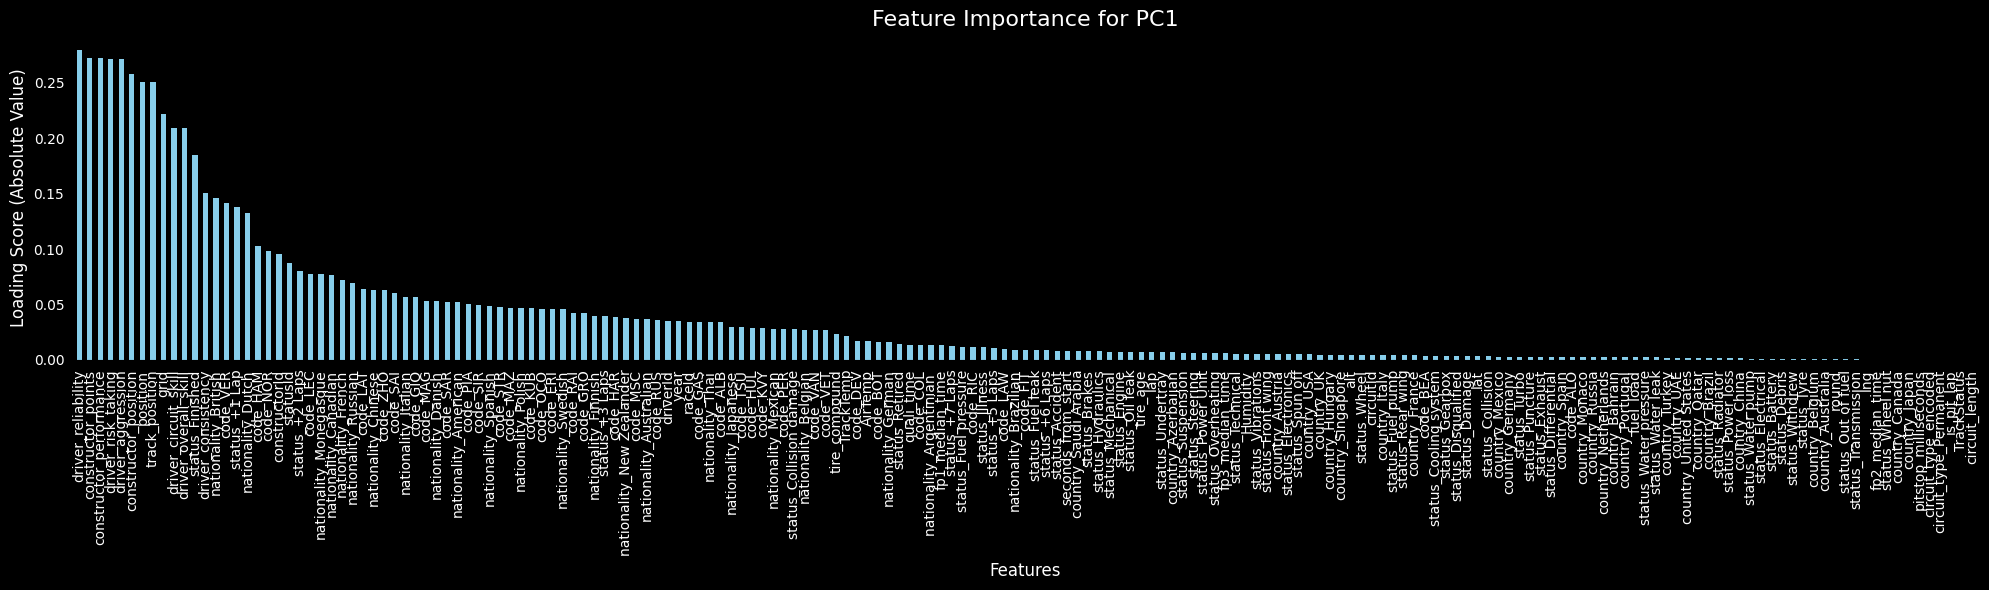

In [6]:
import matplotlib.pyplot as plt

# Bar plot for feature importance in PC1
plt.figure(figsize=(20, 6))
important_features_pc1.plot(kind="bar", color="skyblue")  # Bar color

# Customize the plot
plt.title("Feature Importance for PC1", fontsize=16, color="white")  # Title in white
plt.ylabel(
    "Loading Score (Absolute Value)", fontsize=12, color="white"
)  # Y-axis label in white
plt.xlabel("Features", fontsize=12, color="white")  # X-axis label in white

# Change tick colors to white
plt.xticks(rotation=90, fontsize=10, color="white")  # X-ticks in white
plt.yticks(fontsize=10, color="white")  # Y-ticks in white

# Change background color
plt.gca().set_facecolor("black")  # Axes background color
plt.gcf().set_facecolor("black")  # Figure background color

plt.tight_layout()
plt.show()

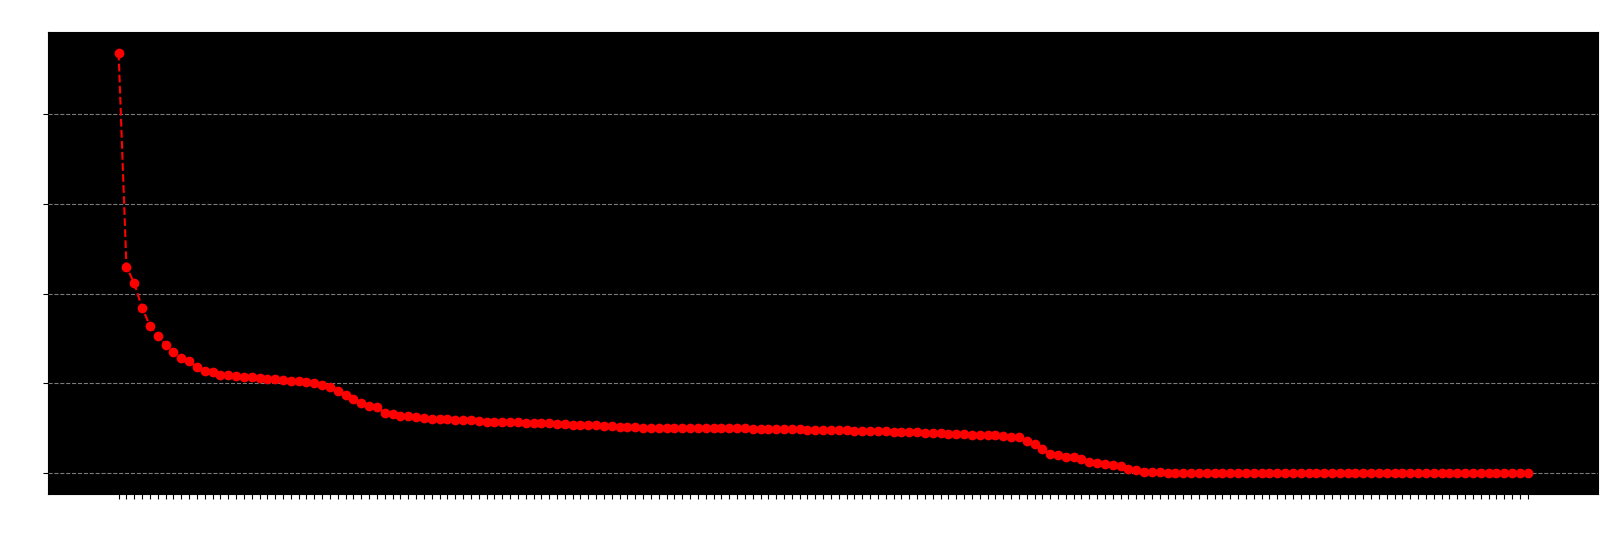

In [7]:
# Scree plot
plt.figure(figsize=(20, 6))
plt.plot(
    range(1, len(eigenvalues) + 1), eigenvalues, marker="o", linestyle="--", color="r"
)
plt.title("Scree Plot", color="white")
plt.xlabel("Principal Component Index", color="white")
plt.ylabel("Eigenvalue", color="white")
plt.xticks(range(1, len(eigenvalues) + 1), color="white")
plt.yticks(color="white")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.gca().set_facecolor("black")  # Set the background color to black
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

# Perform initial train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y, test_size=0.2, random_state=42
)

# Further split the training set into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train,
    y_train,
    test_size=0.25,
    random_state=42,  # 0.25 * 0.8 = 0.2 of the total data
)

# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_validation shape:", X_validation.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_validation shape:", y_validation.shape)
print("y_test shape:", y_test.shape)

X_train shape: (77835, 181)
X_validation shape: (25946, 181)
X_test shape: (25946, 181)
y_train shape: (77835,)
y_validation shape: (25946,)
y_test shape: (25946,)


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.decomposition import PCA

# Define a range of n_components to try
n_components_range = range(1, 165)  # Example range from 1 to 10

# Initialize a dictionary to store RMSE for each n_components
rmse_dict = {}

for n_components in n_components_range:
    # Apply PCA with the current number of components
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_validation_pca = pca.transform(X_validation)
    
    # Initialize the linear regression model
    log_reg_pca = LinearRegression()
    
    # Train the model
    log_reg_pca.fit(X_train_pca, y_train)
    
    # Make predictions on the validation set
    y_pred_pca = log_reg_pca.predict(X_validation_pca)
    
    # Calculate RMSE
    rmse = root_mean_squared_error(y_validation, y_pred_pca)
    rmse_dict[n_components] = rmse
    print(f"n_components: {n_components}, RMSE: {rmse}")

# Find the best n_components with the lowest RMSE
best_n_components = min(rmse_dict, key=rmse_dict.get)
print(f"Best n_components: {best_n_components}, RMSE: {rmse_dict[best_n_components]}")

n_components: 1, RMSE: 11464.30652183345
n_components: 2, RMSE: 10650.062408048592
n_components: 3, RMSE: 6709.807573577532
n_components: 4, RMSE: 6489.961666684636
n_components: 5, RMSE: 6421.714015936972
n_components: 6, RMSE: 6421.616775779706
n_components: 7, RMSE: 6284.74013984781
n_components: 8, RMSE: 5926.285444400058
n_components: 9, RMSE: 5810.530887581048
n_components: 10, RMSE: 5804.831670430652
n_components: 11, RMSE: 5799.744168405664
n_components: 12, RMSE: 5779.586805018236
n_components: 13, RMSE: 5755.655406791024
n_components: 14, RMSE: 5755.482257916175
n_components: 15, RMSE: 5739.872472329586
n_components: 16, RMSE: 5736.144047316403
n_components: 17, RMSE: 5728.445648111875
n_components: 18, RMSE: 5723.884509037958
n_components: 19, RMSE: 5723.8278704573695
n_components: 20, RMSE: 5722.7046165515685
n_components: 21, RMSE: 5722.628914556166
n_components: 22, RMSE: 5708.419889681169
n_components: 23, RMSE: 5707.5878606762
n_components: 24, RMSE: 5707.535438547657
n

In [10]:
# Save the trained model to a .pth file
#from linear_regression_utils import save

#torch.save(log_reg_pca, 'models/linear_regression_model.pth')

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

# Initialize the RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_rf = rf_regressor.predict(X_validation)

# Calculate RMSE
rmse_rf = root_mean_squared_error(y_validation, y_pred_rf)
print(f"Random Forest RMSE: {rmse_rf}")

In [13]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV


# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42, )

# Train the model
xgb_regressor.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_xgb = xgb_regressor.predict(X_validation)

# Calculate RMSE
rmse_xgb = root_mean_squared_error(y_validation, y_pred_xgb)
print(f"XGBoost RMSE: {rmse_xgb}")

XGBoost RMSE: 1079.570283168948


In [14]:
# Download [houses dataset](https://www.openml.org/d/537) from OpenML. The task is to predict median price of the house in the region based on demographic composition and a state of housing market in the region.
from flaml import AutoML

automl = AutoML()
settings = {
    "time_budget": 200,  # total running time in seconds
    "metric": "mse",  # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": [
        "xgboost"
    ],  # list of ML learners; we tune XGBoost in this example
    "task": "regression",  # task type
    "log_file_name": "f1regression.log",  # flaml log file
    "seed": 7654321,  # random seed
}
automl.fit(X_train=X_train, y_train=y_train, X_val=X_validation, y_val=y_validation, **settings)

[flaml.automl.logger: 12-01 21:51:31] {1728} INFO - task = regression
[flaml.automl.logger: 12-01 21:51:31] {1736} INFO - Data split method: uniform
[flaml.automl.logger: 12-01 21:51:31] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 12-01 21:51:31] {1838} INFO - Minimizing error metric: mse
[flaml.automl.logger: 12-01 21:51:31] {1955} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 12-01 21:51:31] {2258} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 12-01 21:51:31] {2393} INFO - Estimated sufficient time budget=3787s. Estimated necessary time budget=4s.
[flaml.automl.logger: 12-01 21:51:31] {2442} INFO -  at 1.2s,	estimator xgboost's best error=84823455.1218,	best estimator xgboost's best error=84823455.1218
[flaml.automl.logger: 12-01 21:51:31] {2258} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 12-01 21:51:31] {2442} INFO -  at 1.2s,	estimator xgboost's best error=84823455.1218,	best estimator xgboo

In [15]:
print("Best hyperparmeter config:", automl.best_config)
print("Best r2 on validation data: {0:.4g}".format(1 - automl.best_loss))
print("Training duration of best run: {0:.4g} s".format(automl.best_config_train_time))

model = automl.model.estimator

y_pred_flaml = automl.predict(X_test)
print("Predicted labels", y_pred_flaml)

# Calculate RMSE
rmse_flaml = root_mean_squared_error(y_validation, y_pred_flaml)
print(f"FLAML RMSE: {rmse_flaml}")


Best hyperparmeter config: {'n_estimators': 250, 'max_leaves': 1502, 'min_child_weight': np.float64(0.005509243602083528), 'learning_rate': np.float64(0.06075495644865563), 'subsample': np.float64(0.8167010147464543), 'colsample_bylevel': np.float64(0.5433866575388816), 'colsample_bytree': np.float64(0.7494605427158806), 'reg_alpha': np.float64(1.3745263818629416), 'reg_lambda': np.float64(13.451358482213815)}
Best r2 on validation data: -1.045e+06
Training duration of best run: 9.176 s
Predicted labels [ 82546.12   92192.96  100892.61  ...  86118.14   98517.19   75122.914]
FLAML RMSE: 16186.475324581914


<BarContainer object of 175 artists>

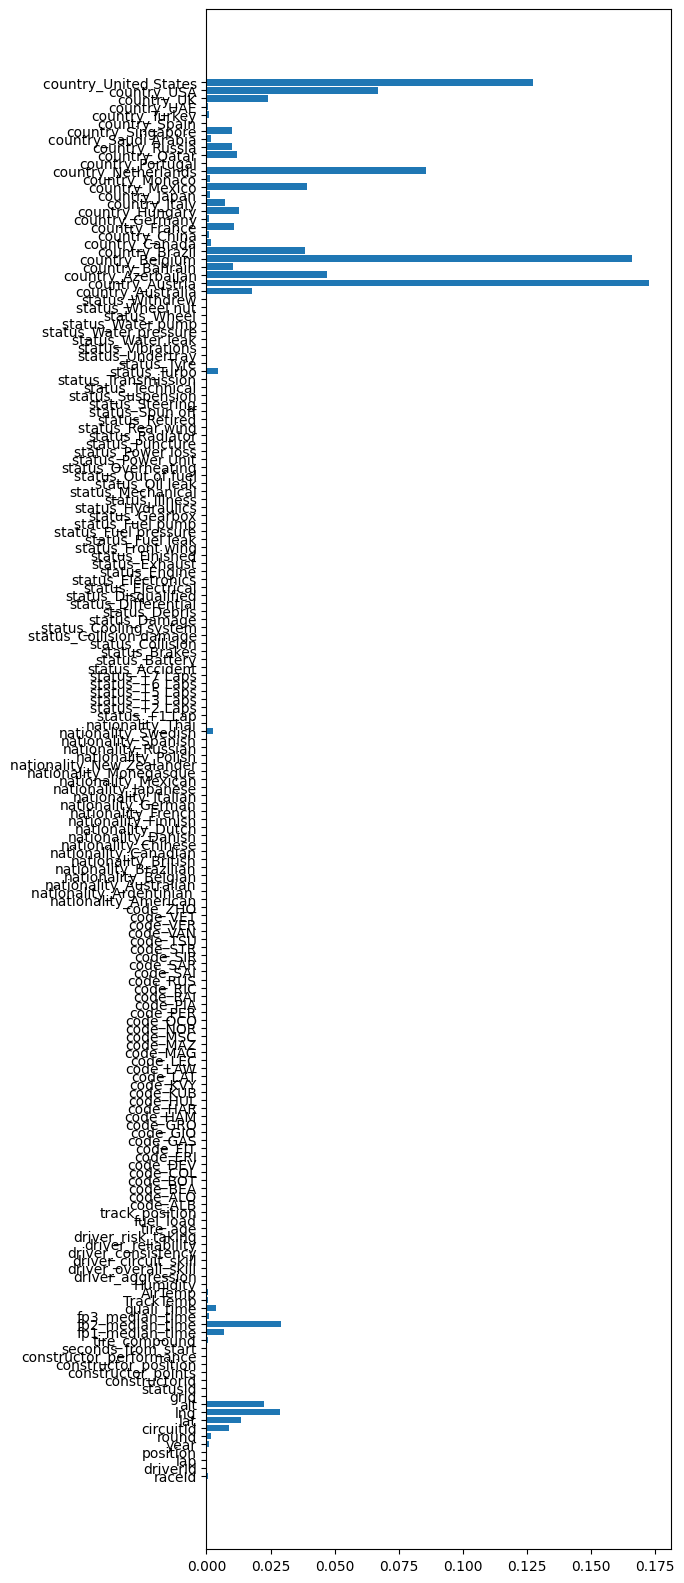

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 20))
plt.barh(automl.feature_names_in_, automl.feature_importances_)

In [17]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Make predictions on the test set for Linear Regression with PCA
X_test_pca = pca.transform(X_test_normalized)
y_pred_pca_test = log_reg_pca.predict(X_test_pca)

# Make predictions on the test set for Random Forest
y_pred_rf_test = rf_regressor.predict(X_test_normalized)

# Make predictions on the test set for XGBoost
y_pred_xgb_test = xgb_regressor.predict(X_test_normalized)

# Make predictions on the test set for FLAML
y_pred_flaml_test = automl.predict(X_test_normalized)

# Calculate RMSE for Linear Regression with PCA
rmse_linear_pca = np.sqrt(mean_squared_error(y_test, y_pred_pca_test))
print(f"Linear Regression with PCA RMSE: {rmse_linear_pca}")

# Calculate RMSE for Random Forest
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf_test))
print(f"Random Forest RMSE: {rmse_rf}")

# Calculate RMSE for XGBoost
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb_test))
print(f"XGBoost RMSE: {rmse_xgb}")

# Calculate RMSE for FLAML
rmse_flaml = np.sqrt(mean_squared_error(y_test, y_pred_flaml_test))
print(f"FLAML RMSE: {rmse_flaml}")

NameError: name 'X_test_normalized' is not defined

In [ ]:
plt.style.use('dark_background')
plot_predictions(y_test, y_pred_flaml_test, model_name="XGBoost")